In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
#from sklearn.externals 
import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [4]:
electronics_data=pd.read_csv("ratings_Electronics.csv",names=['userId', 'productId','Rating','timestamp'])

In [5]:
electronics_data.head()

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [6]:
electronics_data.shape

(7824482, 4)

In [7]:
#Tomando subconjunto do conjunto de dados
electronics_data=electronics_data.iloc[:1048576,0:]

In [8]:
#Verifique os tipos de dados
electronics_data.dtypes

userId        object
productId     object
Rating       float64
timestamp      int64
dtype: object

In [9]:
electronics_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048576 entries, 0 to 1048575
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   userId     1048576 non-null  object 
 1   productId  1048576 non-null  object 
 2   Rating     1048576 non-null  float64
 3   timestamp  1048576 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 32.0+ MB


In [10]:
#Resumo de cinco pontos
electronics_data.describe()['Rating'].T

count    1.048576e+06
mean     3.973380e+00
std      1.399329e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

In [11]:
#Encontrando as classificações mínimas e máximas
print('Minimum rating is: %d' %(electronics_data.Rating.min()))
print('Maximum rating is: %d' %(electronics_data.Rating.max()))

Minimum rating is: 1
Maximum rating is: 5


In [12]:
#Verificar valores ausentes
print('Number of missing values across columns: \n',electronics_data.isnull().sum())

Number of missing values across columns: 
 userId       0
productId    0
Rating       0
timestamp    0
dtype: int64


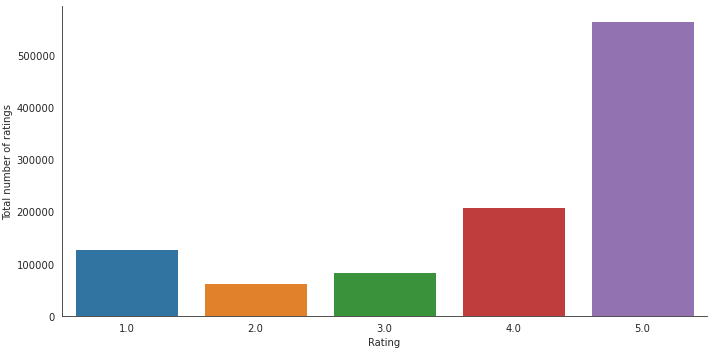

In [13]:
# Verificando a distribuição da classificação
with sns.axes_style('white'):
    g = sns.factorplot("Rating", data=electronics_data, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

## A maioria das pessoas deu a classificação de 5

In [15]:
print("Dados totais ")
print("-"*50)
print("\nNº total de avaliações :",electronics_data.shape[0])
print("Nº  total de usuários   :", len(np.unique(electronics_data.userId)))
print("Nº total de produtos :", len(np.unique(electronics_data.productId)))

Dados totais 
--------------------------------------------------

Nº total de avaliações : 1048576
Número total de usuários   : 786330
Nº total de produtos : 61894


In [18]:
#Removendo a coluna Timestamp
electronics_data.drop(['timestamp'], axis=1,inplace=True)

In [19]:
##Análise da classificação dada pelo usuário
no_of_rated_products_per_user = electronics_data.groupby(by='userId')['Rating'].count().sort_values(ascending=False)

no_of_rated_products_per_user.head()

userId
A5JLAU2ARJ0BO     412
A231WM2Z2JL0U3    249
A25HBO5V8S8SEA    164
A6FIAB28IS79      146
AT6CZDCP4TRGA     128
Name: Rating, dtype: int64

In [20]:
no_of_rated_products_per_user.describe()

count    786330.000000
mean          1.333506
std           1.385612
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         412.000000
Name: Rating, dtype: float64

In [21]:
quantiles = no_of_rated_products_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'Quantis e seus valores')

<AxesSubplot:title={'center':'Quantis e seus valores'}>

Text(0, 0.5, 'Nº de avaliações por usuário')

Text(0.5, 0, 'Valor no quantil')

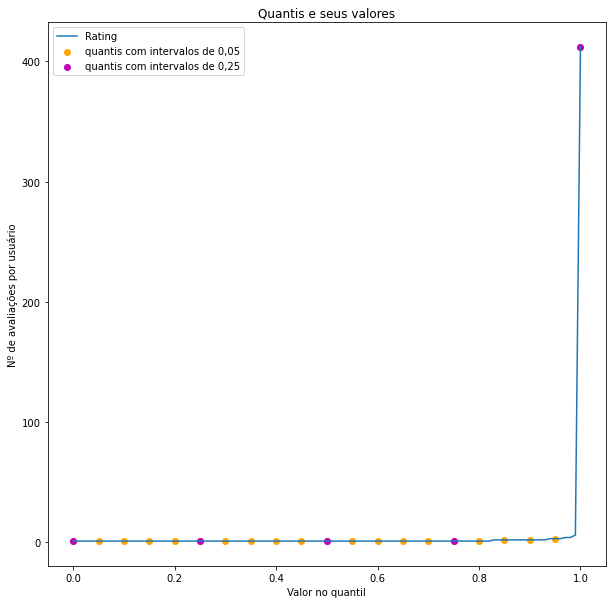

In [23]:
plt.figure(figsize=(10,10))
plt.title("Quantis e seus valores")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantis com intervalos de 0,05")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantis com intervalos de 0,25")
plt.ylabel('Nº de avaliações por usuário')
plt.xlabel('Valor no quantil')
plt.legend(loc='best')
plt.show()

In [25]:
print('\n N.º de produtos com classificação superior a 50 por utilizador : {}\n'.format(sum(no_of_rated_products_per_user >= 50)) )


 N.º de produtos com classificação superior a 50 por utilizador : 38



In [27]:
#Obtendo o novo dataframe que contém usuários que deram 50 ou mais avaliações
new_df=electronics_data.groupby("productId").filter(lambda x:x['Rating'].count() >=50)

Text(0.5, 1.0, 'CLASSIFICAÇÕES por produto')

Text(0.5, 0, 'Product')

Text(0, 0.5, 'Nº de classificações por produto')

[Text(-500.0, 0, ''),
 Text(0.0, 0, ''),
 Text(500.0, 0, ''),
 Text(1000.0, 0, ''),
 Text(1500.0, 0, ''),
 Text(2000.0, 0, ''),
 Text(2500.0, 0, ''),
 Text(3000.0, 0, ''),
 Text(3500.0, 0, ''),
 Text(4000.0, 0, ''),
 Text(4500.0, 0, '')]

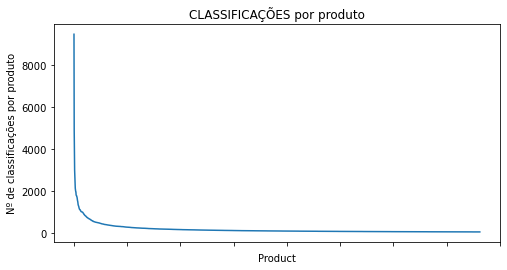

In [29]:
no_of_ratings_per_product = new_df.groupby(by='productId')['Rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title('CLASSIFICAÇÕES por produto')
plt.xlabel('Product')
plt.ylabel('Nº de classificações por produto')
ax.set_xticklabels([])

plt.show()

In [30]:
new_df.groupby('productId')['Rating'].mean().head()

productId
0972683275    4.470980
1400501466    3.560000
1400501520    4.243902
1400501776    3.884892
1400532620    3.684211
Name: Rating, dtype: float64

In [31]:
new_df.groupby('productId')['Rating'].mean().sort_values(ascending=False).head()

productId
B0000DYV9H    4.947368
B000053HC5    4.945783
B00009R96C    4.885714
B00005LE76    4.879310
B000I1X3W8    4.869565
Name: Rating, dtype: float64

In [32]:
#Total no of rating for product

new_df.groupby('productId')['Rating'].count().sort_values(ascending=False).head()

productId
B0002L5R78    9487
B0001FTVEK    5345
B000I68BD4    4903
B000BQ7GW8    4275
B00007E7JU    3523
Name: Rating, dtype: int64

In [33]:
ratings_mean_count = pd.DataFrame(new_df.groupby('productId')['Rating'].mean())

In [34]:
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('productId')['Rating'].count())

In [35]:
ratings_mean_count.head()

,Rating,rating_counts
productId,,
0972683275,4.470980,1051
1400501466,3.560000,250
1400501520,4.243902,82
1400501776,3.884892,139
1400532620,3.684211,171


In [36]:
ratings_mean_count['rating_counts'].max()

9487

<Figure size 576x432 with 0 Axes>

<AxesSubplot:>

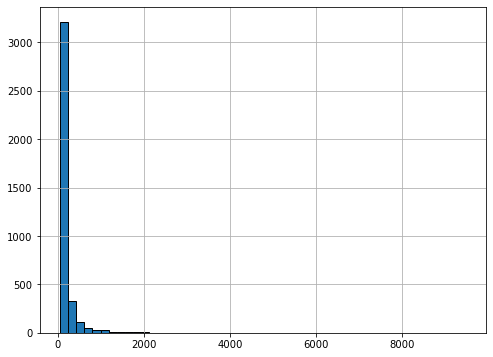

In [37]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=50)

<Figure size 576x432 with 0 Axes>

<AxesSubplot:>

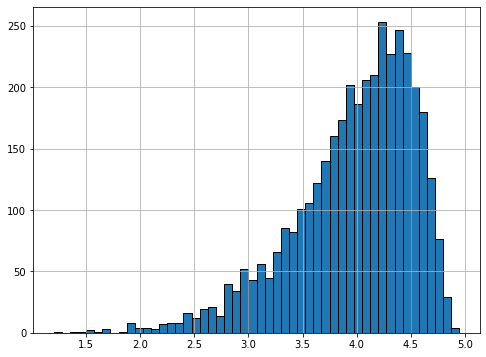

In [38]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['Rating'].hist(bins=50)

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

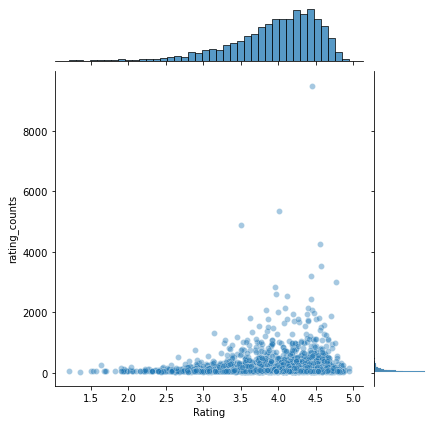

In [39]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='Rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)

<AxesSubplot:xlabel='productId'>

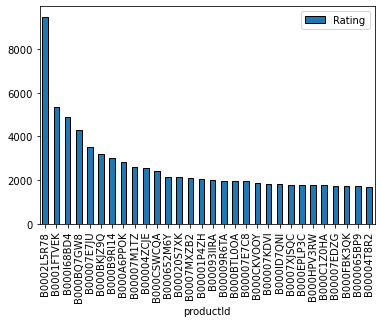

In [40]:
popular_products = pd.DataFrame(new_df.groupby('productId')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending=False)
most_popular.head(30).plot(kind = "bar")

<h1>Filtragem colaborativa (recomendação item-item)</h1>
<h4>A filtragem colaborativa é comumente usada para sistemas de recomendação. Essas técnicas visam preencher as entradas faltantes de uma matriz de associação usuário-item. Vamos usar a abordagem de filtragem colaborativa (CF). A CF baseia-se na ideia de que as melhores recomendações vêm de pessoas que têm gostos semelhantes. Em outras palavras, ele usa classificações históricas de itens de pessoas com ideias semelhantes para prever como alguém classificaria um item. A filtragem colaborativa tem duas subcategorias que são geralmente chamadas de abordagens baseadas em memória e baseadas em modelos..</h4>

In [43]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split

In [45]:
#Lendo o conjunto de dados
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(new_df,reader)

In [46]:

#Dividindo o conjunto de dados
trainset, testset = train_test_split(data, test_size=0.3,random_state=10)

In [47]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [48]:
# run the trained model against the testset
test_pred = algo.test(testset)

In [49]:
test_pred

[Prediction(uid='A2CTXDLXKOHCEH', iid='B00003CWDH', r_ui=5.0, est=4.050870065449826, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='ABGCDODB3OLPE', iid='B0002D6QJO', r_ui=3.0, est=4.050870065449826, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='AIL0HKZRRCE3L', iid='B00097CUIE', r_ui=5.0, est=4.050870065449826, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='AQ2SRQCX77658', iid='B000FVDD30', r_ui=5.0, est=4.46122953351869, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='AQR9NP6PBTSPT', iid='B00007LTBA', r_ui=1.0, est=4.050870065449826, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='AXOY9UHP9HJNX', iid='B0002L5R78', r_ui=5.0, est=4.050870065449826, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='AKLRRKLW8NYRO', iid='B0002344GG', r_ui=1.0,

In [50]:
# get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 1.3436


1.343641161111319

<h1>Sistema de filtragem colaborativa baseado em modelo</h1>
<p>Esses métodos são baseados em técnicas de aprendizado de máquina e mineração de dados. O objetivo é treinar modelos para serem capazes de fazer previsões. Por exemplo, poderíamos usar interações de usuário-item existentes para treinar um modelo para prever os 5 principais itens que um usuário pode gostar mais. Uma vantagem desses métodos é que eles podem recomendar um número maior de itens para um número maior de usuários, em comparação com outros métodos, como a abordagem baseada em memória. Eles têm grande cobertura, mesmo ao trabalhar com grandes matrizes esparsas.</p>


In [51]:
new_df1=new_df.head(10000)
ratings_matrix = new_df1.pivot_table(values='Rating', index='userId', columns='productId', fill_value=0)
ratings_matrix.head()

productId,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400532736,1400599997,1400698987,...,B00000JFMK,B00000JHWX,B00000JI4F,B00000JII6,B00000JMUG,B00000JPPI,B00000JSGF,B00000JYLO,B00000JYWQ,B00000K135
userId,,,,,,,,,,,,,,,,,,,,,
A01852072Z7B68UHLI5UG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0266076X6KPZ6CCHGVS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0293130VTX2ZXA70JQS,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A030530627MK66BD8V4LN,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0571176384K8RBNKGF8O,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
ratings_matrix.shape

(9832, 76)

In [53]:
X = ratings_matrix.T
X.head()

userId,A01852072Z7B68UHLI5UG,A0266076X6KPZ6CCHGVS,A0293130VTX2ZXA70JQS,A030530627MK66BD8V4LN,A0571176384K8RBNKGF8O,A0590501PZ7HOWJKBGQ4,A0641581307AKT5MAOU0Q,A076219533YHEV2LJO988,A0821988FXKFYX53V4QG,A099626739FNCRNHIKBCG,...,AZWOPBY75SGAM,AZX0ZDVAFMN78,AZX5LAN9JEAFF,AZX7I110AF0W2,AZXKUK895VGSM,AZXP46IB63PU8,AZYTSU42BZ7TP,AZZGJ2KMWB7R,AZZMV5VT9W7Y8,AZZST8OYL5P4Q
productId,,,,,,,,,,,,,,,,,,,,,
0972683275,0,0,5,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400501466,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400501520,0,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
1400501776,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1400532620,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
X.shape

(76, 9832)

In [55]:
X1 = X

In [56]:
#Decompondo a Matriz
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(76, 10)

In [57]:
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(76, 76)

In [58]:
X.index[75]

'B00000K135'

In [59]:
i = "B00000K135"

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

75

<p>Correlação de todos os itens com o 
item comprado por este cliente com 
base em itens avaliados por outros 
clientes que compraram o mesmo produto</p>

In [60]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(76,)

<p>Recomendar os 25 principais produtos altamente correlacionados em sequência</p>

In [61]:
Recommend = list(X.index[correlation_product_ID > 0.65])


# Remove o item já comprado pelo cliente
Recommend.remove(i) 

Recommend[0:24]

['1400532736',
 '1400599997',
 '1400698987',
 '6301977173',
 '9575871979',
 '9625993428',
 '9966694544',
 '9984984354',
 '9985511476',
 'B000001OM4',
 'B00000J05A',
 'B00000J08Q',
 'B00000J0D2',
 'B00000J0D8',
 'B00000J1EP',
 'B00000J1EQ',
 'B00000J1F3',
 'B00000J1UQ',
 'B00000J1V3',
 'B00000JD34',
 'B00000JFMK',
 'B00000JHWX',
 'B00000JMUG',
 'B00000JPPI']

<p>Aqui estão os 10 principais produtos a serem exibidos pelo sistema de recomendação ao cliente acima com base no histórico de compras de outros clientes no site.</p>